### Volatility Modeling, Master Mathematics for Finance and Data (MFD), Ecole des Ponts ParisTech and Université Gustave Eiffel, 2022-23
# Computing assignment

### Due Date: 1:30 PM Monday, February 27
You should turn in the notebook at the Educnet website.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

Text(0, 0.5, 'Y')

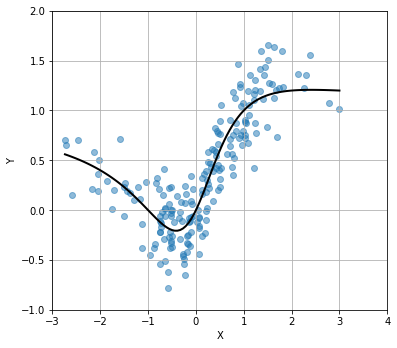

In [10]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

n = 200
sigma = 0.25
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

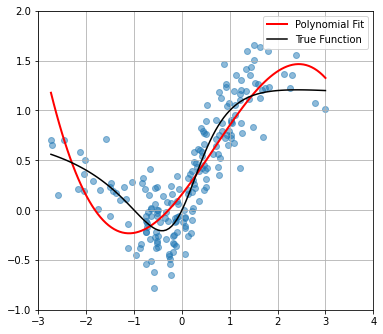

In [11]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)

### Piecewise Linear Regression

In [12]:
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

Text(0, 0.5, 'Y')

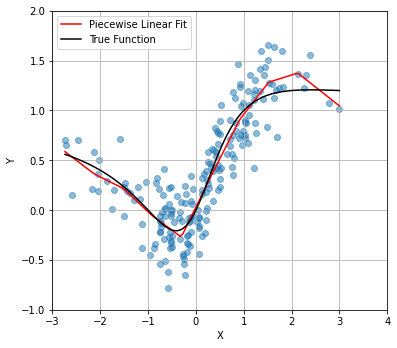

In [13]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X=x\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [18]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

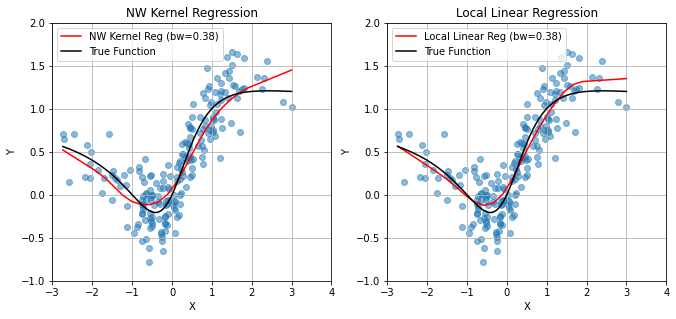

In [22]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

## Questions

<b>(a)</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overftting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use different numbers of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

<b>(b)</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example
$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere.}$$
Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

# 2. The Particle Method and Smile Calibration

<!--<h3 style="color:deepskyblue">The Particle Method and Smile Calibration</h3>-->

Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{loc}}(t,S) \equiv 15\%$.

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

## Questions

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first exercise. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.

<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.

<b>(e).</b> Consider the forward-starting call spread with payoff
\begin{equation*}
\left( \frac{S_{T_2}}{S_{T_1}}-0.95 \right)_+ - \left( \frac{S_{T_2}}{S_{T_1}}-1.05 \right)_+
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [2]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [3]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [4]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2